# LLLplus Tutorial

Lattice reduction and related lattice tools are used in cryptography, digital communication, and integer programming. The [LLLplus.jl](https://github.com/christianpeel/LLLplus.jl) package includes several lattice reduction tools, a CVP problem solver, and more. This notebook gives an introductory tutorial on lattices and lattice reduction and then shows the application of LLLplus tools in wireless communications, cryptography, and integer programming.

### Intro to lattices

What is a lattice? For an $m$ by $n$ matrix $H$ with $m\ge n$, then the set of points $\mathbf{y}=H\mathbf{x}$ for any integer valued vector $\mathbf{x}$ is a lattice.

Let's illustrate this with an $m=n=2$ case. Rather than looking all possible vectors $\mathbf{x}$, let's look at vectors with values from $-2,\ldots,2$, represented by the columns of the following matrix $X$:

In [1]:
X = [ -2  -2  -2  -2  -2  -1  -1  -1  -1  -1   0   0  0  0  0   1   1  1  1  1   2   2  2  2  2
      -2  -1   0   1   2  -2  -1   0   1   2  -2  -1  0  1  2  -2  -1  0  1  2  -2  -1  0  1  2];

Let's see what these points look like:

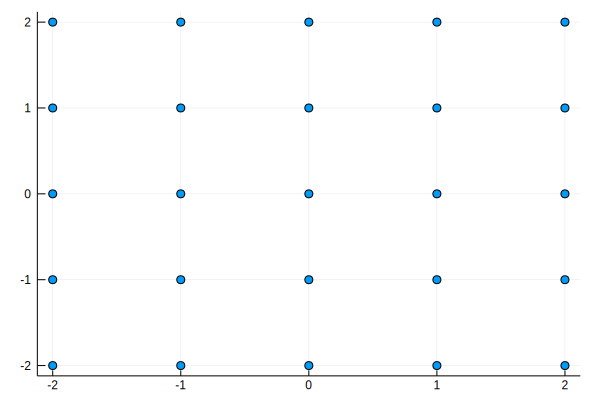

In [2]:
using Plots
plot(X[1,:],X[2,:], linealpha = 0,markershape=:circle,legend=false)

Hopefully this plot looks like a subset of $\mathbb{Z}^2$ to you.

So what about a lattice?  Let's look at a specially-chosen lattice, illustrated by the matrix $H$ below, and plot it.

In [3]:
H = [ 2.5       -1.5     
 0.866025  -0.866025]
Y = H*X

2×25 Array{Float64,2}:
 -2.0  -3.5       -5.0      -6.5      …  6.5      5.0      3.5       2.0
  0.0  -0.866025  -1.73205  -2.59808     2.59808  1.73205  0.866025  0.0

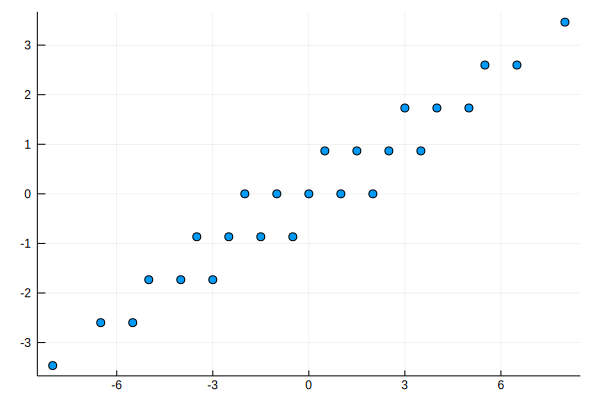

In [4]:
plot(Y[1,:],Y[2,:], linealpha = 0,markershape=:circle,legend=false)

Despite the different shapes, the first two figures above contain the *same* number of points.

A *lattice* really means that we are spanning the entire $\mathbb{Z}^2$ space; in the figure above we're only looking a subset of those points.  To get a better feel for what's going on, we'll define the function 'count' below. The only thing you need to know is that it allows us to look at a larger set of 'lattice' points without writting the explicit `X` vector down.

In [5]:
function count(M,N)
    s = zeros(M,N^M)
    z = (1:N^M) .-1
    for n = 0:M-1
        m = floor.(z/N)
        s[M-n,:] = z .- N.*m
        z = m
    end
    return s
end
X = Int.(count(2,13) .- 6)
Y = H*X

2×169 Array{Float64,2}:
 -6.0  -7.5       -9.0      -10.5      …  10.5      9.0      7.5       6.0
  0.0  -0.866025  -1.73205   -2.59808      2.59808  1.73205  0.866025  0.0

We'll plot the same lattice, with the same plot window (same x and y domain), just with the larger number of points in X.

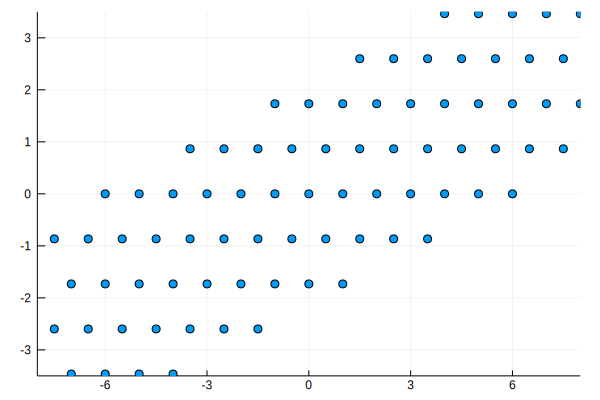

In [6]:
plot(Y[1,:],Y[2,:], linealpha = 0,markershape=:circle,legend=false,xlims=(-8,8),ylims=(-3.5,3.5))

### Lattice Reduction
Since the lattice is over the entire $\mathbb{Z}^2$ space, it's natural to ask if there's a different matrix which will generate the same points. Hopefully, this new lattice will be less skew.

This is what [Lenstra, Lenstra, Lovász](https://en.wikipedia.org/wiki/Lenstra%E2%80%93Lenstra%E2%80%93Lov%C3%A1sz_lattice_basis_reduction_algorithm) (LLL) lattice reduction does.  It decomposes a matrix `H` into a matrix `B` that is still a basis for the lattice that `H` makes, yet has shorter vectors and is closer to orthogonal. It also returns a unimodular (determinant= +/-1) integer valued matrix `T` such that `H T= B`.   

Let's take the LLL decomposition of our `H` from above and plot the resulting lattice.

In [7]:
using LLLplus
B,T = lll(H); B

2×2 Array{Float64,2}:
 1.0  -0.5     
 0.0   0.866025

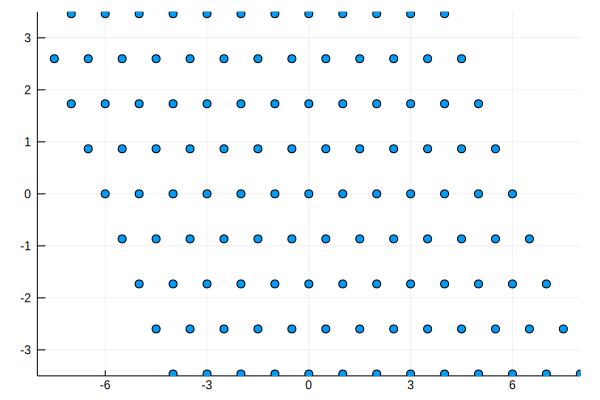

In [8]:
Y = B*X
plot(Y[1,:],Y[2,:], linealpha = 0,markershape=:circle,legend=false,xlims=(-8,8),ylims=(-3.5,3.5))

If you compare the two figures above, you'll see that they cover the same lattice points.  The lattice basis is also less skew. 

What does that matrix `T` contain?  Does `T` really have determinant of +/- 1?  The lines below show that this is true.  You can check yourself that the inverse of `T` is also integer-valued, and the determinant of the inverse is also +/- 1.

In [9]:
T

2×2 Array{Int64,2}:
 1  -2
 1  -3

In [10]:
det(T)

-1.0

### CVP

The "closest vector problem" is to find the closest point in a lattice to a point in the same underlying space.  Specifically, given the lattice induced by a  matrix `H`, and a vector `y`, find the integer-valued vector `x` that such that `Hx` is closest to `y`.  

$$\hat{\mathbf{x}} = \arg\min_{x \in \mathbf{Z}^n} ||y-Hx||_2$$

Let's look at an example:

In [11]:
H=[1 2; 3 4]
x=[2,-1]
y=H*x + randn(2)/10

2-element Array{Float64,1}:
 0.029940685725328726
 2.1336665272450257  

Without noise `Hx` would be `[0,2]`; the addition of noise moves it away from that baseline.

The `cvp` function in LLLplus requires that we use a QR decomposition to prepare the data. Runing the code, we find we can recover the initial `x` vector.

In [12]:
Q,R=qr(H)
x̂ = cvp(Q'*y,R)

2-element Array{Float64,1}:
  2.0
 -1.0

### Application to Digital communication

A wireless system with multiple antennas at both the transmitter and receiver is often referred to as a multiple-input, multiple-output (MIMO) system. Some engineers and researchers have proposed "Massive-MIMO" systems with hundreds of antennas. Let's look at decoding a binary signal sent on each antenna of such a system.  *Some details that everyone but wireless gurus can ignore: we'll assume a synchronized, narrow-band system, with no correlation between antennas and no impairments other than thermal noise*. Let's assume `n` antennas at each transmitter and receiver, with the propogation channel between each transmit and each receive antenna represented by one entry in a `n` by `n` matrix `H`.  The propgation matrix `H` reflects on how the transmitted signal bounced off of buildings and other metal surfaces between the transmitter and receiver. We will also add gaussian thermal noise `w`. The overal model is 
    $$\mathbf{y} = H\mathbf{x} + \mathbf{w}$$
Let's simulate this system:

In [13]:
n=100                   # Let's use 100 antennas
x=Int.(rand(0:1,n))     # A binary signal is transmitted from each tx anteanna
H=randn(n,n)            # channel coefficients btwn each tx and rx antenna

# send the signal through the channel
w = rand(n)/10          # thermal noise
y=H*x+w                 # received data

# decode the signal
Q,R=qr(H)               # The receiver is assumed to know H via training (not modeled)
x̂=cvp(Q'*y,R)

# check if we decoded the signal correctly
sum(abs.(x-x̂))          # Success!

0.0

The signal is decoded correctly.

Use of lattice tools such as a cvp solver, or using lattice-reduction typically gives much better performance to a broadband wireless system than simple linear receivers (such as `round(inv(H)*y)` ). These principles apply to LTE, WiFi, and many other digital communications problems. It's possible that the difference between the figures in this [article](https://9to5mac.com/2016/10/20/iphone-7-qualcomm-intel-modem-cellular-performance/) is that Qualcomm is using a nonlinear (CVP, LLL, etc...) receiver, while Intel is using a simpler, but poorer-performance linear receiver.

### Subset-sum problem

In the subset-sum problem, one is given a set of numbers `a`, a sum `s`, with the goal of finding whether some subset of `a` sums to `s`.  Specifically, if `a` is a vector, then is there a binary vector `x` such that `x'*a==s`?  The `subsetsum` function implements the Lagarias and Odlyzko (1983) technique which uses the LLL algorithm to find a polynomial-time solution to the problem. The LLL has been used to crack the [Merkle-Hellman](https://en.wikipedia.org/wiki/Merkle%E2%80%93Hellman_knapsack_cryptosystem) cryptosystem, and has been part of many other cryptoanalytic attacks.

We do not dive into the details of the `subsetsum` function, rather we give two examples, starting with an example that can be visually inspected to be correct.

In [14]:
a=[1,2,4,9,20,38]
s=30
x=subsetsum(a,s)

6-element Array{Float64,1}:
 1.0
 0.0
 0.0
 1.0
 1.0
 0.0

In [15]:
# check the result
s==x'*a

true

The second example sets the vector `a` to be integers sampled uniformly from the range `[1:2^256]`.  Despite the large bit-depth of the integers, the LLL-based technique solves the problem quickly.

In [16]:
N=40
a=rand(1:2^BigInt(256),N)

40-element Array{BigInt,1}:
  52966019994847903947942438279253224710179175905054670645485359246712459937580
  60284285807960226905685998406630132778973408018084486443877102388277646793029
  88088434549054603795035220275158003859278583319576200298335243431186049890688
 102216526612158525608427694592741849895831500557382123931052317507192769873414
 111366934726704812336357159967275227136813435253283639477131741118741497414209
  68312097531131194452312516287134976387408608625158155795157983708319827992525
  55125975044263260301331673399718883155408719786422595646401499451424633490680
  47238834081716529338009400277108320358882359342047456245665496785110661486235
  72736875888792828199967782662535352416765087576704047857802048708869240140699
  16782831561841572851701628030674265972955034348219805218945406149166119288657
 111518864133851420097778624452034324362035413739427444854597266606003627923669
  57831768993344032657816302725040745056254556148878139499279348917001800710818
  9709825278

In [17]:
xtrue=rand(Bool,N)
s=a'*xtrue
setprecision(BigFloat,300)
x=subsetsum(a,s)
s==x'*a

true

### Integer Programming Feasibility Problem

The integer programming feasibility problem is: given an `m` by `n` matrix `A`, and an `m`-dimensional vector `d`, determine if there is an `x` such that `Ax≤d`.  For a fixed `n`, H.W. Lenstra (1983) gave a polynomial time solution, which we illustrate in the `integerfeasibility` function. We do not go into the details of the technique, rather illustrate it with a simple example.

In [18]:
A=[10 1 -9; 1 8 8]
xtrue=[0; 2; 9]
d=A*xtrue;
x̂= integerfeasibility(A,d)
xtrue==x̂

true

In a more complex example, we set the values of the `20x30` matrix `A` to be uniform from `-10:10` and the `30`-dimensional vector `x` to have values taken uniformly from `0:10`. The `integerfeasibility` function finds the solution quickly.

In [19]:
n=20
m=30
xtrue = rand(0:10,m)
A = rand(-10:10,n,m)

20×30 Array{Int64,2}:
  -1    9   -2    4  -9   4   -4  -8  …    9    1   3  -3  -5    3   8    6
   4   -5    5    8   6  -3   -3  -7      -9    2   1  -2  -6    7   3   -4
  10   -2    6    9  -5  -5  -10   7      -1  -10   5  -4  -3   -1   1  -10
  -7  -10   -5    9  -7  10    9  -3      10   -6  -5  -4   1    2   0    5
   8   -7    7    7   0  -7    2  -2      -2    3   4   1  -2    4  -7   -1
  -3   -4  -10    0   9   5    2  -7  …    6    7   1  -3   3    3  10   -5
   4   -4    1  -10   6   2   -9  -3      -2    2  -8   7  -3   -5  -7    9
  -4   -6   -2   -6  -1   3   10  -4      -9    4   4  -7  -6    9  -5    8
   3   -6   -2    8   5   1   -4  -2       3    8   9  -1  -7   10   0   -8
  -5    2    0    7   0   9    0   0      -3   -8  -2   7  -7   -7   6    4
   5   -4   -3    8   4  -2    7  -7  …   -5    6  -7  -9   5   -5  -6   -6
 -10    3    6    9   0  -6    8   6      -8    8  -7   5  -7   -1  -3   -6
  -3  -10    5    8   6   9   10   4      -5   -8   9   1  -8    8

In [20]:
d=A*xtrue;
x̂ = integerfeasibility(A,d)
xtrue == x̂

true

### Why Julia?

Why write LLLplus in Julia? The C++ library [fplll](https://github.com/fplll/fplll) is a widely-used, fast, and robust lattice toolbox and is a reasonable choice for many. Even so, there are several advantages to native Julia code. For example, the same Julia code can accept matrices of integers, floats, [DoubleFloats](https://github.com/JuliaMath/DoubleFloats.jl), Float128s from [Quadmath](https://github.com/JuliaMath/Quadmath.jl), BigInts, BigFloats, and likely others. Hopefully LLLplus can also be used in other ways as part of a composable Julia  program.

Want to learn more about lattice techniques? If you want a broad survey, try ["The LLL Algorithm"](https://www.springer.com/us/book/9783642022944).  The algorithm pseudocode in the [monograph by Bremner](https://www.amazon.com/Lattice-Basis-Reduction-Introduction-Applications/dp/1439807027) and the [survey paper](http://www.ant.uni-bremen.de/sixcms/media.php/102/10740/SPM_2011_Wuebben.pdf) were helpful to me. 